# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [1]:
import tensorflow as tf
from tqdm import tqdm_notebook
import time

from IPython.display import display, HTML
display(HTML("<style>.container { width:78% !important; }</style>"))

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape, y_train.shape)


(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

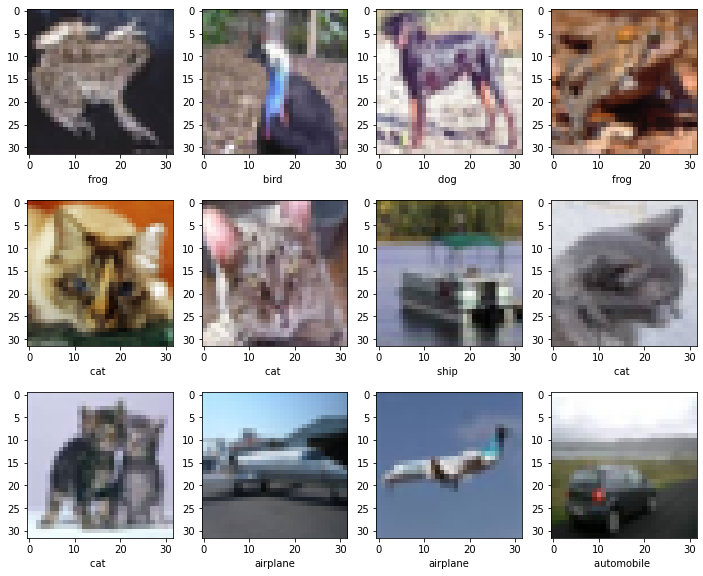

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [7]:
model_mlp = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(10, activation='softmax'),
    ]
)

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


In [8]:
dummy_pred = model_mlp.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 132ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [9]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [10]:
my_callback = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

In [11]:
model_mlp.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_mlp.fit(X_train,
          y_train,
          batch_size=32,
          epochs=100,
          validation_data=[X_val, y_val],
          callbacks=[my_callback])

Epoch 1/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9103 - accuracy: 0.3127 - val_loss: 1.7636 - val_accuracy: 0.3729
Epoch 2/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7237 - accuracy: 0.3895 - val_loss: 1.6619 - val_accuracy: 0.4063
Epoch 3/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6393 - accuracy: 0.4193 - val_loss: 1.6469 - val_accuracy: 0.4130
Epoch 4/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5823 - accuracy: 0.4416 - val_loss: 1.6791 - val_accuracy: 0.3871
Epoch 5/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5330 - accuracy: 0.4574 - val_loss: 1.5542 - val_accuracy: 0.4485
Epoch 6/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4970 - accuracy: 0.4715 - val_loss: 1.5135 - val_accuracy: 0.4609
Epoch 7/100
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4645 - accuracy: 0.4823 - val_loss: 1.4857 - val_ac

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [12]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model_mlp.predict(X_test), axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 0s 836us/step

 Test_acc = 0.5367
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [13]:
model_conv = keras.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')])

model_conv.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_conv.fit(X_train,
          y_train,
          batch_size=32,
          epochs=100,
          validation_data=[X_val, y_val],
          callbacks=[my_callback])

Epoch 1/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9421 - accuracy: 0.3085 - val_loss: 1.7222 - val_accuracy: 0.3955
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6340 - accuracy: 0.4252 - val_loss: 1.5316 - val_accuracy: 0.4627
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4744 - accuracy: 0.4783 - val_loss: 1.4354 - val_accuracy: 0.4913
Epoch 4/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3796 - accuracy: 0.5091 - val_loss: 1.3710 - val_accuracy: 0.5109
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3150 - accuracy: 0.5357 - val_loss: 1.3126 - val_accuracy: 0.5384
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2681 - accuracy: 0.5500 - val_loss: 1.2847 - val_accuracy: 0.5493
Epoch 7/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2276 - accuracy: 0.5670 - val_loss: 1.2699 - val_ac

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [14]:
test_acc = accuracy_score(y_test, np.argmax(model_conv.predict(X_test), axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.6073
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [15]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X_test), axis=1))))

In [16]:
optimizers = {
    'sgd': 'sgd',
    'rmsprop': 'rmsprop',
    'adam': 'adam'
}

models = {
    'MLP': model_mlp,
    'Convolutional': model_conv
}

my_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

In [17]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[my_callbacks])
evaluator.evaluate(X_test, y_test, accuracy_score)

C:\Users\79111\AppData\Local\Temp\ipykernel_15768\2420383808.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/6 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 45.
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 37.
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 39.
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 26.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 34: early stopping
313/313 [==============================] - 0s 1ms/step
Final score of MLP_sgd is 0.5383
313/313 [==============================] - 0s 1ms/step
Final score of MLP_rmsprop is 0.4617
313/313 [==============================] - 0s 788us/step
Final score of MLP_adam is 0.4807
313/313 [==============================] - 1s 2ms/step
Final score of Convolutional_sgd is 0.6109
313/313 [==============================] - 1s 2ms/step
Final score of Convolutional_rmsprop is 0.6212
313/313 [==========

### Прокомментируйте полученные результаты.
Для ускорения работы класса `Evaluator` я использовал `EarlyStopping Callback`, чтобы модели в процессе обучения не обязательно проходили все 100 эпох, а останавливались, если оцениваемая метрика не улучшается на протяжении 20 эпох. Конечно же есть вероятность того, что модель в будущих эпохах могла бы еще дообучиться, но вероятность того, что она в результате переобучится я бы оценил выше. Кроме того мой `Callback` в конце обучения восстанавливает для моделей те веса, на которых они давала наилучший результат на валидационной выборке.

Ниже приведены изображения кривых обучения, полученных из `TensorBoard`. Я оставил кривые только для валидационных выборок. По ним можно сделать вывод, что сверточная нейросеть вне зависимости от оптимизатора гораздо быстрее сходится, и в целом лучше справляется с поставленной задачей, чем многослойный персептрон. Хотя, судя по графикам потерь можно отметить, что персептрон менее склонен к переобучению.

Если сравнивать работу сверточной нейросети с различными оптимизаторами, то на мой взгляд лучше всех себя показал `RMSProp`. Он сошелся быстрее всех, достигнув наилучшего показателя метрики уже на 11 эпохе. Это также подтверждается работой получившейся модели на тестовой выборке, где `accuracy_score` равен `0.6212`. Для сравнения, `SGD` сошелся на 26 эпохе и на тестовой выборке показал `accuracy_score` `0.6109` - это третье место. На втором месте оказался `Adam`, который сошелся на 14 эпохе и на тестовой выборке показал `accuracy_score` `0.6113`.

Рассматривая графики потерь, нельзя не обратить внимание на то, что при всех отмеченных плюсах `RMSProp` очень резко переходит в переобучение, достигнув хорошего показателя метрики на 11 эпохе. Такого нельзя сказать про `SGD`, и в меньшей степени можно сказать про `Adam`. В этой ситуации использование раннего останова становится обязательным условием для получения адекватной модели.

### Изменение val_categorical_accuracy в течение эпох
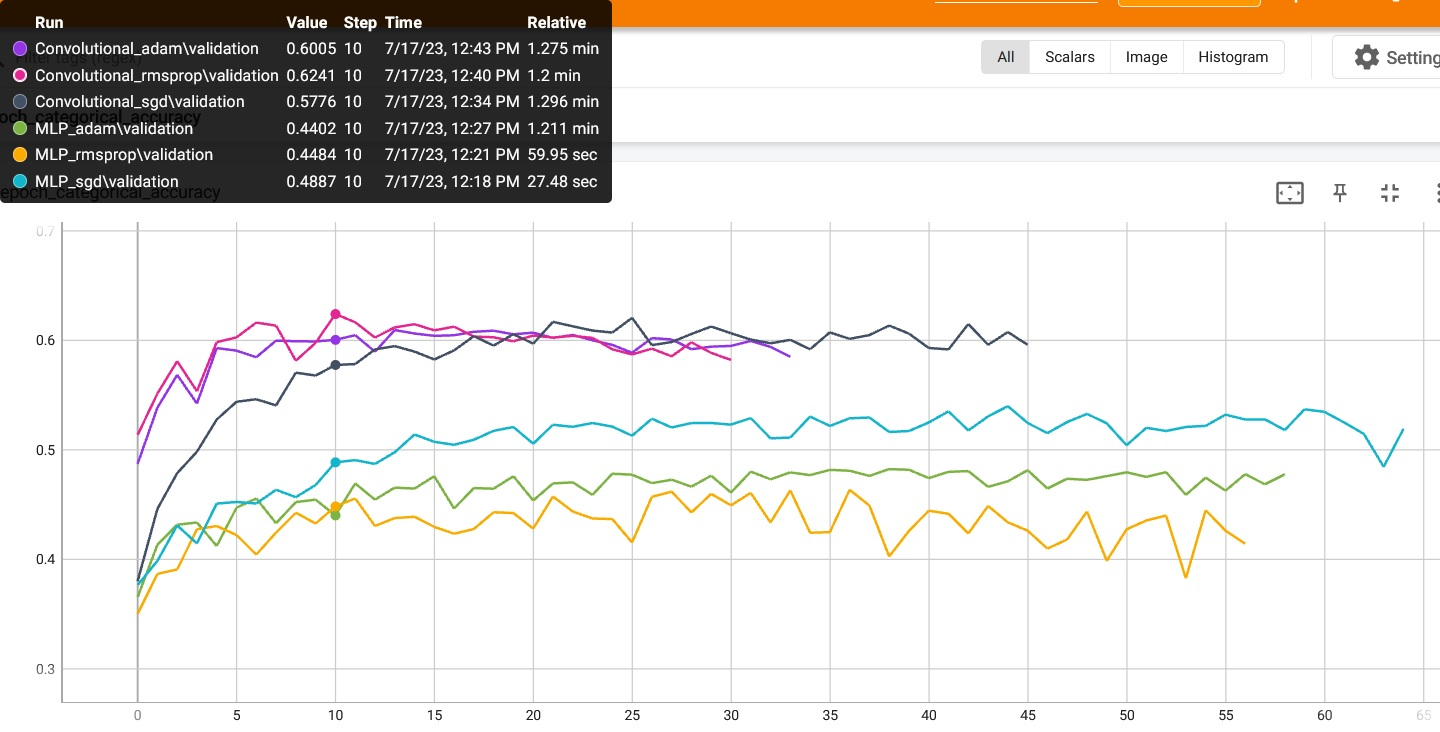

### Изменение categorical_crossentropy в течение эпох
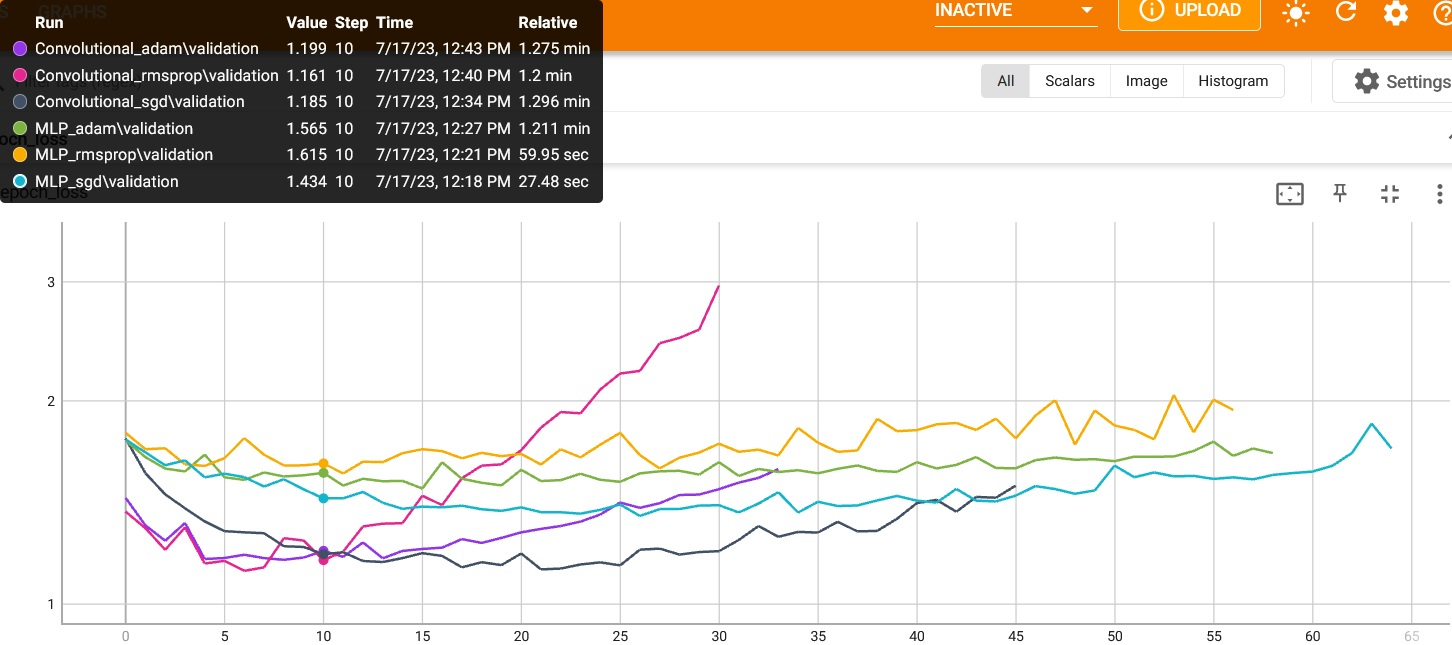

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

In [38]:
model_conv_batchnorm = keras.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3,3),
                        padding='same',
                        activation=None,
                        input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')])

In [39]:
model_conv_batchnorm.compile(optimizer='sgd',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

model_conv_batchnorm.save_weights('model_conv_batchnorm_weights')

model_conv_batchnorm.fit(X_train,
                         y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=[X_val, y_val],
                         callbacks=[my_callback])

Epoch 1/100
1250/1250 [==============================] - 9s 7ms/step - loss: 1.6062 - accuracy: 0.4350 - val_loss: 1.6463 - val_accuracy: 0.4209
Epoch 2/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.3087 - accuracy: 0.5411 - val_loss: 1.7738 - val_accuracy: 0.4166
Epoch 3/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1779 - accuracy: 0.5898 - val_loss: 1.3994 - val_accuracy: 0.5189
Epoch 4/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0997 - accuracy: 0.6159 - val_loss: 1.2076 - val_accuracy: 0.5815
Epoch 5/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0343 - accuracy: 0.6409 - val_loss: 1.2477 - val_accuracy: 0.5755
Epoch 6/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9783 - accuracy: 0.6600 - val_loss: 1.1264 - val_accuracy: 0.6070
Epoch 7/100
1250/1250 [==============================] - 13s 10ms/step - loss: 0.9322 - accuracy: 0.6769 - val_loss: 1.1798 - val

In [40]:
test_acc = accuracy_score(y_test, np.argmax(model_conv_batchnorm.predict(X_test), axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.6149
 Not bad!


### Прокомментируйте полученные результаты.
Сверточная нейросеть с `SGD` в качестве оптимизатора и с добавлением `BatchNormalization` между свёрткой и активацией, а также в полносвязном слое перед активацией сошлась на 22 эпохе и продемонстрировала `accuracy_score` на тестовой выборке `0.6149`. Для сравнения, сверточная нейросеть с `SGD` без нормализации в предыдущих экспериментах сошлась сначала за 25 эпох с `accuracy_score` `0.6073`, и затем в результате работы класса `Evaluator` за 26 эпох с `accuracy_score` `0.6109`.

Пока сложно сказать является ли улучшение показателей заслугой `BatchNormalization`, или случайностью. Но отмечаем, что улучшение все-таки есть.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [41]:
class EarlyStoppingByAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') >= 0.55:
            print("\n !!! 55% accuracy, no further training !!!")
            self.model.stop_training = True

In [42]:
my_callback_acc = EarlyStoppingByAccuracy()

batch_sizes_dict = {}

for bs in [4, 8, 16, 32, 64, 128, 256]:
    model_conv_batchnorm.load_weights('model_conv_batchnorm_weights')
    
    start_time = time.time()
    model_conv_batchnorm.fit(X_train,
                             y_train,
                             batch_size=bs,
                             epochs=100,
                             validation_data=[X_val, y_val],
                             callbacks=[my_callback_acc])
    
    the_time = time.time() - start_time
    batch_sizes_dict[bs] = the_time

Epoch 1/100
10000/10000 [==============================] - 26s 3ms/step - loss: 1.7614 - accuracy: 0.3738 - val_loss: 1.4073 - val_accuracy: 0.5047
Epoch 2/100
10000/10000 [==============================] - 25s 3ms/step - loss: 1.5654 - accuracy: 0.4498 - val_loss: 1.3616 - val_accuracy: 0.5210
Epoch 3/100
10000/10000 [==============================] - 25s 2ms/step - loss: 1.5050 - accuracy: 0.4730 - val_loss: 1.4281 - val_accuracy: 0.4995
Epoch 4/100
10000/10000 [==============================] - 25s 2ms/step - loss: 1.4539 - accuracy: 0.4927 - val_loss: 1.3031 - val_accuracy: 0.5338
Epoch 5/100
10000/10000 [==============================] - 25s 2ms/step - loss: 1.4039 - accuracy: 0.5098 - val_loss: 1.3115 - val_accuracy: 0.5395
Epoch 6/100
 9979/10000 [============================>.] - ETA: 0s - loss: 1.3797 - accuracy: 0.5203
 !!! 55% accuracy, no further training !!!
10000/10000 [==============================] - 25s 2ms/step - loss: 1.3800 - accuracy: 0.5203 - val_loss: 1.1525 - v

In [43]:
for key, value in batch_sizes_dict.items():
    print(f'batch_size: {key}, 55% accuracy fit time: {value}')

batch_size: 4, 55% accuracy fit time: 151.06627416610718
batch_size: 8, 55% accuracy fit time: 29.786000967025757
batch_size: 16, 55% accuracy fit time: 20.871726036071777
batch_size: 32, 55% accuracy fit time: 36.126471757888794
batch_size: 64, 55% accuracy fit time: 41.946253538131714
batch_size: 128, 55% accuracy fit time: 47.58442997932434
batch_size: 256, 55% accuracy fit time: 76.92920684814453


### Прокомментируйте полученные результаты.
Быстрее всего точности 55% модель достигает с размером батча 16, на это уходит всего 21 секунда. С батчем 8 модель тратит 30 секунд, а с батчем 32 - 36 секунд. Дальше с увеличением батча времени затрачивается все больше.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

**Для этого эксперимента я создам еще две нейросети с нормализацией по батчу. В одной из них оставлю нормализацию только между свёрткой и активацией, а в другой только в полносвязном слое перед активацией. Буду сравнивать между собой эти две нейросети и предыдущую, в которой `BatchNormalization` был в обоих местах. Также для каждой нейросети буду тестировать уже опробованные ранее оптимизаторы `SGD` `RMSProp` и `Adam`.**

In [46]:
model_conv_batchnorm_in_conv = keras.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3,3),
                        padding='same',
                        activation=None,
                        input_shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')])

In [47]:
model_conv_batchnorm_in_dense = keras.Sequential([
    keras.layers.Conv2D(filters=10,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')])

In [48]:
optimizers = {
    'sgd': 'sgd',
    'rmsprop': 'rmsprop',
    'adam': 'adam'
}

models = {
    'Batchnorm in both': model_conv_batchnorm,
    'Batchnorm in Conv2D': model_conv_batchnorm_in_conv,
    'Batchnorm in Dense': model_conv_batchnorm_in_dense
}

my_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

In [49]:
evaluator = Evaluator(models, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[my_callbacks])
evaluator.evaluate(X_test, y_test, accuracy_score)

C:\Users\79111\AppData\Local\Temp\ipykernel_15768\2420383808.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/9 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 19.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 36: early stopping
313/313 [==============================] - 1s 3ms/step
Final score of Batchnorm in both_sgd is 0.6204
313/313 [==============================] - 1s 3ms/step
Final score of Batchnorm in both_rmsprop is 0.6073
313/313 [=====================

### Прокомментируйте полученные результаты.
Ниже приведены изображения кривых обучения, полученных из `TensorBoard`.

- Нейросеть с `SGD` без нормализации сходится за большее количество эпох (26) и при этом немного проигрывает в качестве, показываемом на тестовой выборке. Модели с нормализацией сходились за 19, 12 и 16 эпох.


- `RMSProp` позволил сойтись заметно быстрее моделям с нормализацией в обоих слоях и с нормализацией в полносвязном слое, на это потребовалось всего 4 эпохи. Модель с нормализацией в сверточном слое сходилась долше остальных, 17 эпох. Что касается качества на тестовой выборке, то здесь преимущество небольшое у модели без нормализации.


- Из моделей с использованием `Adam` быстрее всех сошлась нейросеть с нормализацией в обоих слоях, за 4 эпохи. Результат остальных в этом плане примерно одинаковый 13, 14 и 16 эпох. В плане качества на тестовой выборке они тоже примерно равны.

Я бы сказал, что примерно равны в результирующем качестве все рассмотренные на этот момент сверточные нейросети. Из них наихудший результат метрики `accuracy_score` на тестовый выборке `0.5994` у модели на `Adam` и с нормализацией только в сверточном слое. И этот результат не сильно хуже `0.6212`, который показала модель без нормализации на `RMSProp`. Заметнее, пожалуй, `BatchNormalization` влияет на сходимость. Во многих случаях он позволил нейросетям сходиться за существенно меньшее количество эпох.

Стоит отметить при этом, что кривые обучения моделей с `BatchNormalization` получаются с резкими скачками, в то время как отсутствие нормализации делает кривые более плавными. В моем понимании "наилучшая" кривая должна как раз быть более плавной, нежели скачкообразной. Однако нормализация по батчу позволяет заметно замедлить переобучение, что видно по графикам потерь на валидационной выборке. Они не улетают моментально вверх после достижения моделью локального минимума а дольше остаются на одном уровне, `BatchNormalization` позволяет нейросети выучить более общие закономерности в данных и таким образом не переобучиться.

С учетом сделанных мною выводов из всех рассмотренных моделей в качестве бейслайна я бы выбрал сверточную нейросеть без `BatchNormalization` с оптимизатором `Adam`. Кривая `val_categorical_accuracy` этой модели сходится почти так же быстро, как у модели на `RMSProp`, но при этом, судя по кривой потерь, `Adam` делает нейросеть существенно менее склонной к переобучению. Мне это видится компромиссным решением между `SGD` и `RMSProp`.

### Изменение val_categorical_accuracy в течение эпох SGD
<img src="sgd_epoch_val_categorical_accuracy.jpg" width="800">

### Изменение val_categorical_accuracy в течение эпох RMSProp
<img src="rmsprop_epoch_val_categorical_accuracy.jpg" width="800">

### Изменение val_categorical_accuracy в течение эпох Adam
<img src="adam_epoch_val_categorical_accuracy.jpg" width="800">

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

### Как я продолжу
Ранее я определил для себя в качестве бейслайна сверточную нейросеть без `BatchNormalization` с оптимизатором `Adam`. Тем не менее я сразу придам дальнейшему процессу обучения дополнительный бустинг и возьму оптимизатор `Nadam`, который является улучшенным Адамом. У меня уже был положительный опыт использования этого оптимизатора. Кроме того, опираясь на предыдущие эксперименты, я установлю `batch_size` для обучения равным 16, так как это значение ранее показало самое скорое достижение моделью точности 55%. Дополнительно я сразу добавлю второй сверточный слой, и установлю больше фильтров: 16 для первой свертки и 32 для второй свертки.

In [10]:
nadam_2Conv = keras.Sequential([
    keras.layers.Conv2D(filters=16,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu',
                        input_shape=X_train.shape[1:]),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),

    keras.layers.Conv2D(filters=32,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),

    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')])

nadam_2Conv.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

my_callback = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0)

nadam_2Conv.fit(X_train,
                y_train,
                batch_size=16,
                epochs=100,
                validation_data=[X_val, y_val],
                callbacks=[my_callback] + [keras.callbacks.TensorBoard(log_dir='./logs/nadam_2Conv')])

Epoch 1/100
2500/2500 [==============================] - 16s 6ms/step - loss: 1.4168 - accuracy: 0.4956 - val_loss: 1.1948 - val_accuracy: 0.5765
Epoch 2/100
2500/2500 [==============================] - 17s 7ms/step - loss: 1.0700 - accuracy: 0.6258 - val_loss: 1.0397 - val_accuracy: 0.6365
Epoch 3/100
2500/2500 [==============================] - 16s 7ms/step - loss: 0.9418 - accuracy: 0.6708 - val_loss: 1.0222 - val_accuracy: 0.6433
Epoch 4/100
2500/2500 [==============================] - 15s 6ms/step - loss: 0.8526 - accuracy: 0.6992 - val_loss: 0.9607 - val_accuracy: 0.6678
Epoch 5/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.7779 - accuracy: 0.7256 - val_loss: 0.9978 - val_accuracy: 0.6610
Epoch 6/100
2500/2500 [==============================] - 19s 8ms/step - loss: 0.7129 - accuracy: 0.7466 - val_loss: 1.0168 - val_accuracy: 0.6577
Epoch 7/100
2500/2500 [==============================] - 22s 9ms/step - loss: 0.6471 - accuracy: 0.7722 - val_loss: 0.9965 -

In [12]:
test_acc = accuracy_score(y_test, np.argmax(nadam_2Conv.predict(X_test), axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 1s 3ms/step

 Test_acc = 0.6754


### И на чем я закончу
На мой взгляд получился неплохой прирост в точности `0.6754`. Напомню, что до этого лучшим результатом `accuracy_score` был `0.6212`. Для следующей, и последней нейросети я добавлю еще два сверточных слоя, всего их будет теперь четыре, и увеличу количество фильтров. В каждом последующем слое фильтров будет больше: 64, 128, 256 и, наконец 512. Также я добавлю `BatchNormalization` и `Dropout` в полносвязном слое перед активацией. Надеюсь это даст мне ощутимый прирост.

In [15]:
nadam_4Conv_batchnorm_dropout_dense = keras.Sequential([
    keras.layers.Conv2D(filters=64,
                        kernel_size=(3,3),
                        padding='same',
                        input_shape=X_train.shape[1:]),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),

    keras.layers.Conv2D(filters=128,
                        kernel_size=(3,3),
                        padding='same'),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Conv2D(filters=256,
                        kernel_size=(3,3),
                        padding='same'),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),
    
    keras.layers.Conv2D(filters=512,
                        kernel_size=(3,3),
                        padding='same'),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), padding='valid'),

    keras.layers.Flatten(),
    keras.layers.Dense(100, activation=None),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')])

nadam_4Conv_batchnorm_dropout_dense.compile(optimizer='nadam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

nadam_4Conv_batchnorm_dropout_dense.fit(X_train,
                y_train,
                batch_size=16,
                epochs=100,
                validation_data=[X_val, y_val],
                callbacks=[my_callback] + [keras.callbacks.TensorBoard(log_dir='./logs/nadam_4Conv_batchnorm_dropout_dense')])

Epoch 1/100
2500/2500 [==============================] - 185s 73ms/step - loss: 1.5372 - accuracy: 0.4505 - val_loss: 1.2318 - val_accuracy: 0.5686
Epoch 2/100
2500/2500 [==============================] - 194s 78ms/step - loss: 1.2003 - accuracy: 0.5810 - val_loss: 1.1016 - val_accuracy: 0.6157
Epoch 3/100
2500/2500 [==============================] - 200s 80ms/step - loss: 1.0622 - accuracy: 0.6352 - val_loss: 1.0380 - val_accuracy: 0.6421
Epoch 4/100
2500/2500 [==============================] - 189s 76ms/step - loss: 0.9591 - accuracy: 0.6694 - val_loss: 0.9010 - val_accuracy: 0.6814
Epoch 5/100
2500/2500 [==============================] - 197s 79ms/step - loss: 0.8698 - accuracy: 0.7018 - val_loss: 0.8036 - val_accuracy: 0.7188
Epoch 6/100
2500/2500 [==============================] - 203s 81ms/step - loss: 0.8066 - accuracy: 0.7271 - val_loss: 0.8918 - val_accuracy: 0.6879
Epoch 7/100
2500/2500 [==============================] - 206s 82ms/step - loss: 0.7449 - accuracy: 0.7471 - val_

Момент истины: проверьте, какого качества достигла ваша сеть.

In [16]:
test_acc = accuracy_score(y_test, np.argmax(nadam_4Conv_batchnorm_dropout_dense.predict(X_test), axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 13ms/step

 Test_acc = 0.7598


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

In [ ]:
%reload_ext tensorboard
%tensorboard --port 6601 --logdir logs

## Итоги
Я не стал приводить здесь все свои эксперименты. В последнем задании предоставил только две модели: промежуточную, и финальную. Мои эксперименты с батчнормом и дропаутом отняли очень много времени, но привели к выводу, что для этого задания их лучше не использовать в сверточных слоях.

По итогу, пускай мне не удалось достичь желаемой точности 80% (удалось 76%), но я доволен тем, что получил новые навыки и соображения. В целом вижу огромное пространство для экспериментов, очень интересно работать именно с архитектурами нейросетей и наблюдать в `TensorBoard` за тем, как тот, или иной элемент влияет на обучение модели.

Напоследок приведу пару графиков из Тензорборда, где сравниваются:
- Нейросеть с 2 свертками (**nadam_2Conv**) - мой промежуточный вариант
- Нейросеть с 4 свертками без батчнорма и дропаута (**nadam_4Conv**)
- Нейросеть с 4 свертками с батчнормом и дропаутом в полносвязном слое (**nadam_4Conv_batchnorm_dropout_dense**) - мой лучший вариант
- Нейросеть с 4 свертками только с дропаутом в полносвязном слое (**nadam_4Conv_dropout_dense**)

### Изменение val_categorical_accuracy в течение эпох
<img src="epoch_val_categorical_accuracy_final.jpg" width="800">

### Изменение categorical_crossentropy в течение эпох
<img src="epoch_loss_final.jpg" width="800">